In [89]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.api.types import is_string_dtype, CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
#from keras.preprocessing.sequence import pad_sequences
#authors note, different version of Keras put pad_sequences in different places, if one doesn't work, please try the other
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.utils.data_utils import pad_sequences
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix


In [90]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [91]:
regimes = pd.read_parquet('quarterly_data/df_2020Q1.parquet')
regimes['labels']

usa            0
canada         0
europe         2
uk             0
australia      0
brazil         1
india          1
switzerland    2
japan          2
south korea    0
Name: labels, dtype: int32

In [92]:
countries = regimes[regimes['labels'] == 0].index.tolist()

In [93]:
import re

dfs = []

# Iterate over the countries
for country in countries:
    # Read the Parquet file into a DataFrame
    if country == 'uk':
        country = 'england'
    if country == 'south korea':
        country = 'korea'
    df = pd.read_parquet(f"fed_statements/{country}.parquet")
    df = df.map(lambda x: re.sub(r'[^a-zA-Z0-9\s]|[\n]', '', str(x)) if isinstance(x, str) else x)
    
    # Add the DataFrame to the list
    dfs.append(df)

# Concatenate all the DataFrames along the row axis
data = pd.concat(dfs, axis=0)

In [94]:
data = data.sort_index(ascending=True)

In [95]:
from datetime import datetime, timedelta, time

# Create a copy of your DataFrame to avoid modifying the original data
data_adjusted = data.copy()

# Group by date and check for multiple entries per day
counts = data_adjusted.groupby(data_adjusted.index.normalize()).count()

# Get dates with more than one entry
duplicate_dates = counts[counts > 1].index

# Loop over duplicate dates and adjust the timestamps
for date in duplicate_dates:
    # Get the entries for this date
    entries = data_adjusted[data_adjusted.index.normalize() == date]
    
    # Generate new timestamps by adding a day for each subsequent entry
    new_timestamps = [pd.Timestamp(date + timedelta(days=i)) for i in range(len(entries))]
    
    # Update the index for the entries of this date
    data_adjusted.loc[data_adjusted.index.normalize() == date, 'index'] = new_timestamps

# Set the new index
data_adjusted.set_index('index', inplace=True)

In [96]:
target = pd.read_parquet("data/bonds.parquet")

In [97]:
target_resampled = target['usa'].diff().resample('D').interpolate(method='polynomial', order=2)
# Shift the DataFrame so we are predicting out in time
target_shifted = target_resampled.shift(30)


In [98]:
data_adjusted = data_adjusted.loc[~data_adjusted.index.duplicated(keep='first')]
data_adjusted.shape

(97, 1)

In [99]:
print(target_shifted.index.duplicated().sum())
print(data_adjusted.index.duplicated().sum())

0
0


In [100]:
# Get the common indices
common_indices = target_shifted.index.intersection(data_adjusted.index)

# Select the data from target_shifted and data_adjusted where the index is in common_indices
target_shifted = target_shifted.loc[common_indices]
data_adjusted = data_adjusted.loc[common_indices]


In [101]:
speaches = []
labels = []


for index, row in data_adjusted.iterrows():

	token_list = [x for x in row['content'].split()]

	speaches.append(" ".join(token_list))

In [102]:
# Define some variables
vocab_size = 10000 # max number of words
embedding_dim = 64 # This is the dimension of the Word Vector
max_length = 1000 # maximum length of the sequence
trunc_type = 'post' # where to chop off
padding_type = 'post' # where to put the padding
oov_token = '<OOV>'

In [103]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token = oov_token)

In [104]:
# Assume 'articles' is your list of news stories
tokenizer.fit_on_texts(speaches)

# Convert the articles to sequences of integers
sequences = tokenizer.texts_to_sequences(speaches)

# Pad the sequences so they all have the same length
data = pad_sequences(sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

# Define the window size
window = 5

# Create an array to hold the expanded features
expanded_features = np.zeros((len(data) - window + 1, window, data.shape[1]))

# For each day's news story
for i in range(window, len(data) + 1):
    # Get the past 'window' days' stories
    expanded_features[i - window] = data[i - window:i]

In [105]:
# Make sure the labels array has the same first dimension as your features
assert target_shifted[window-1:].shape[0] == expanded_features.shape[0]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(expanded_features, target_shifted[window-1:].values, test_size=0.15, random_state=42, shuffle=False)

In [106]:
tokenizer.word_index


{'<OOV>': 1,
 'i255': 2,
 'the': 3,
 'of': 4,
 'to': 5,
 'and': 6,
 'in': 7,
 '6': 8,
 '5': 9,
 'a': 10,
 '9': 11,
 '10': 12,
 '11': 13,
 '7': 14,
 'is': 15,
 '2': 16,
 '16': 17,
 '4': 18,
 '12': 19,
 'that': 20,
 '1': 21,
 '14': 22,
 '3': 23,
 '15': 24,
 '8': 25,
 '18': 26,
 '13': 27,
 'for': 28,
 '20': 29,
 'this': 30,
 'we': 31,
 'inflation': 32,
 '19': 33,
 'on': 34,
 '17': 35,
 'are': 36,
 'as': 37,
 '21': 38,
 '22': 39,
 'e': 40,
 'has': 41,
 '24': 42,
 '23': 43,
 'it': 44,
 'our': 45,
 'will': 46,
 'have': 47,
 '26': 48,
 'be': 49,
 'policy': 50,
 'at': 51,
 'i': 52,
 'with': 53,
 'by': 54,
 '27': 55,
 'y': 56,
 '30': 57,
 'rate': 58,
 'bank': 59,
 'monetary': 60,
 't': 61,
 '25': 62,
 '28': 63,
 'been': 64,
 'r': 65,
 '29': 66,
 'also': 67,
 '31': 68,
 'not': 69,
 '34': 70,
 'per': 71,
 'these': 72,
 'from': 73,
 'but': 74,
 'economy': 75,
 'market': 76,
 'was': 77,
 'rates': 78,
 'than': 79,
 'o': 80,
 'some': 81,
 '37': 82,
 'would': 83,
 '0': 84,
 '33': 85,
 'more': 86,
 '32

train word vectors

In [107]:
#sentiment_scores = df_selected.values
# Reshape sentiment_scores to have the same number of columns as data
#data_with_scores = np.concatenate([data, sentiment_scores], axis=1)
print(X_train.shape)
print(len(y_train))

(75, 5, 1000)
75


In [108]:
from tensorflow.keras.layers import Bidirectional

vocab_size = 10000  # or more, depending on your data
embedding_dim = 64
max_length = 1000

model = Sequential()
#model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(5, 1000)))
model.add(Dropout(0.20))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(Dropout(0.20))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.20))
model.add(Dense(1))  # No activation function for regression

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [109]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_15 (Bidirecti  (None, 5, 128)           545280    
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 5, 128)            0         
                                                                 
 bidirectional_16 (Bidirecti  (None, 5, 64)            41216     
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 5, 64)             0         
                                                                 
 bidirectional_17 (Bidirecti  (None, 64)               24832     
 onal)                                                           
                                                      

In [110]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)

history = model.fit(X_train, y_train, validation_data = (X_test, y_test),  batch_size = 12, epochs = 5)

Epoch 1/5
7/7 [==============================] - 16s 398ms/step - loss: 0.0723 - mean_squared_error: 0.0723 - val_loss: 0.1007 - val_mean_squared_error: 0.1007
Epoch 2/5
7/7 [==============================] - 0s 21ms/step - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.1235 - val_mean_squared_error: 0.1235
Epoch 3/5
7/7 [==============================] - 0s 19ms/step - loss: 0.0376 - mean_squared_error: 0.0376 - val_loss: 0.1598 - val_mean_squared_error: 0.1598
Epoch 4/5
7/7 [==============================] - 0s 20ms/step - loss: 0.0362 - mean_squared_error: 0.0362 - val_loss: 0.1296 - val_mean_squared_error: 0.1296
Epoch 5/5
7/7 [==============================] - 0s 20ms/step - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.1462 - val_mean_squared_error: 0.1462


1/1 [==============================] - 2s 2s/step


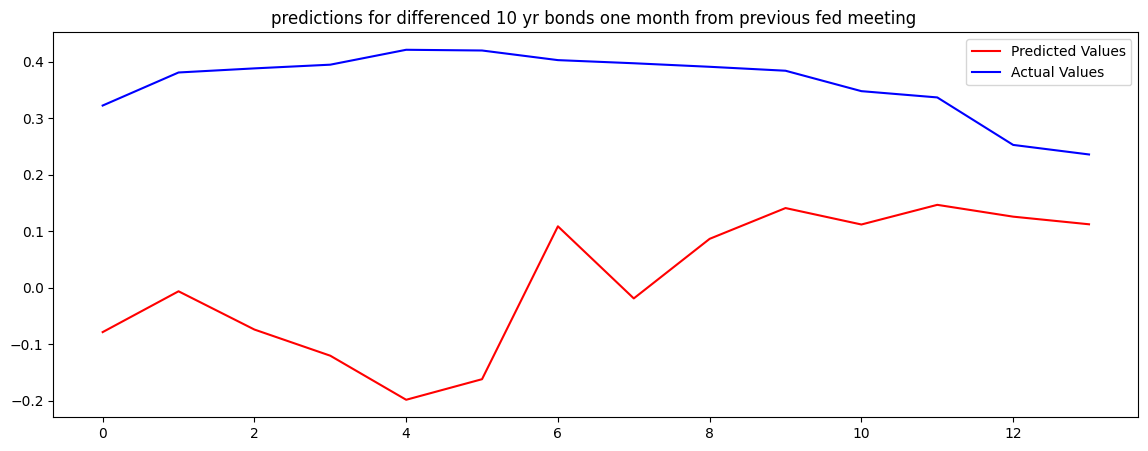

In [111]:
preds = model.predict(X_test)

# Create a range of numbers for your X axis
x_axis = range(len(preds))
#x_axis = X_test.index
# Plot the predictions along with the true values
plt.figure(figsize=(14, 5))
plt.plot(x_axis, preds, 'r', label='Predicted Values')
plt.plot(x_axis, y_test, 'b', label='Actual Values')
plt.title('predictions for differenced 10 yr bonds one month from previous fed meeting ')
plt.legend()
plt.show()


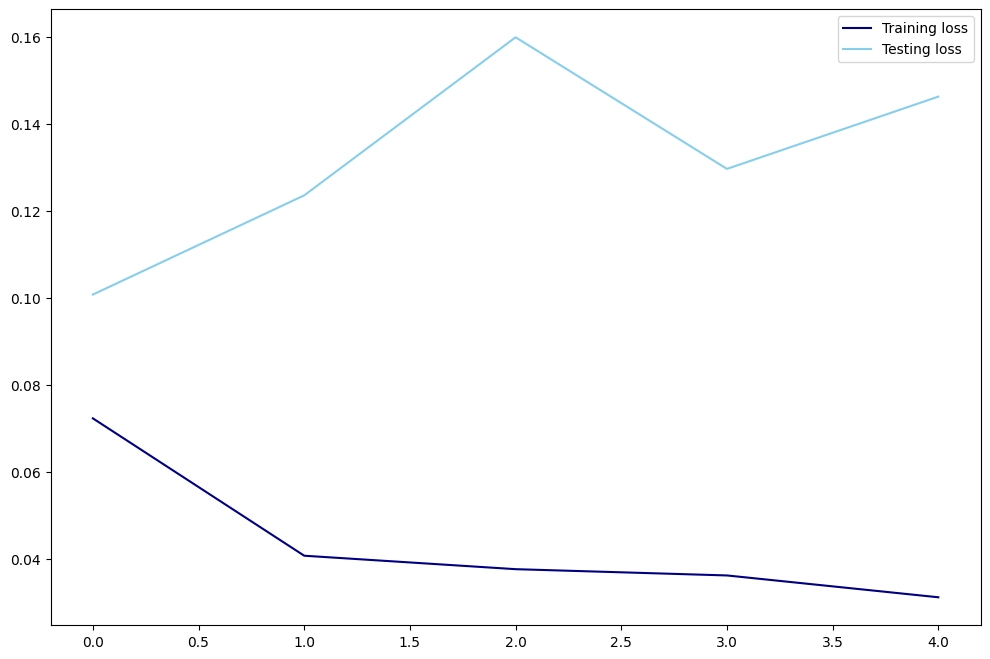

: 

In [112]:
# Visualize the loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();